In [46]:

import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_regression, chi2, mutual_info_regression, SelectPercentile, VarianceThreshold
from sklearn.ensemble import VotingRegressor
from sklearn.preprocessing import MinMaxScaler
from joblib import Parallel, delayed
import numpy as np
from scipy.stats import pearsonr
import multiprocessing
from scipy.cluster import hierarchy
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from collections import Counter


sys.path.append('../../../')

from src.emotion.prediction.aggregates.train import HyperparaSearch
from src.emotion.prediction.aggregates.models import MODELS
from src.emotion.utils.constants import DATA_DIR

%matplotlib inline

In [2]:
features = pd.read_csv('/home/moritz/Workspace/masterthesis/data/features_dataset.csv')

In [3]:
targets = pd.read_csv('/home/moritz/Workspace/masterthesis/data/perma_scores_dataset.csv')

In [4]:
df = pd.merge(features, targets, on=["E-Mail-Adresse", "Day"])

df.shape

(104, 9351)

In [5]:
# Handle Missing Values

df.dropna(axis=1, how='any', inplace=True)
#df = dataset.loc[:, (df != 0).any(axis=0)]

print(df.shape)


(104, 9348)


In [6]:
# Detect outliers

# Check if all PERMA values are the same in each row
same_PERMA = (df['P'] == df['E']) & (df['E'] == df['R']) & (df['R'] == df['M']) & (df['M'] == df['A'])
# Remove the rows where all PERMA values are the same
df = df[~same_PERMA]
print(df.shape)

# find columns where all values are the same
cols_to_drop = [col for col in df.columns if df[col].nunique() == 1]
# drop the columns
df = df.drop(cols_to_drop, axis=1)
print(df.shape)

# drop columns where all values are only 0 or 1
df = df.loc[:, ~(df.isin([0, 1]).all() & ~df.isin([0, 1]).any())]
print(df.shape)

(104, 9348)
(104, 8759)
(104, 8759)


In [7]:
# Load X and Y
# Store the PERMA values in Y
Y = df[['P', 'E', 'R', 'M', 'A']]

# Store the other columns in X
X = df.drop(columns=['ClassID', 'E-Mail-Adresse', 'Day', 'First Name', 'Last Name/Surname', 'P', 'E', 'R', 'M', 'A'])

In [8]:
# Scale Features

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the scaler to the dataframe and transform the dataframe
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)


In [9]:
X.shape

(104, 8749)

In [10]:
corr_matrix = X.corr()

In [11]:
def plot_correlation_matrix(matrix):
    # center the matrix
    matrix = matrix - np.mean(matrix, axis=0)

    # transpose the matrix
    matrix_t = matrix.T

    # compute the correlation matrix using np.corrcoef
    corr_matrix = np.corrcoef(matrix_t)

    # create a heatmap of the correlation matrix using seaborn
    sns.set(font_scale=0.7)
    sns.heatmap(corr_matrix, cmap="YlGnBu")

In [12]:
#plot_correlation_matrix(X)

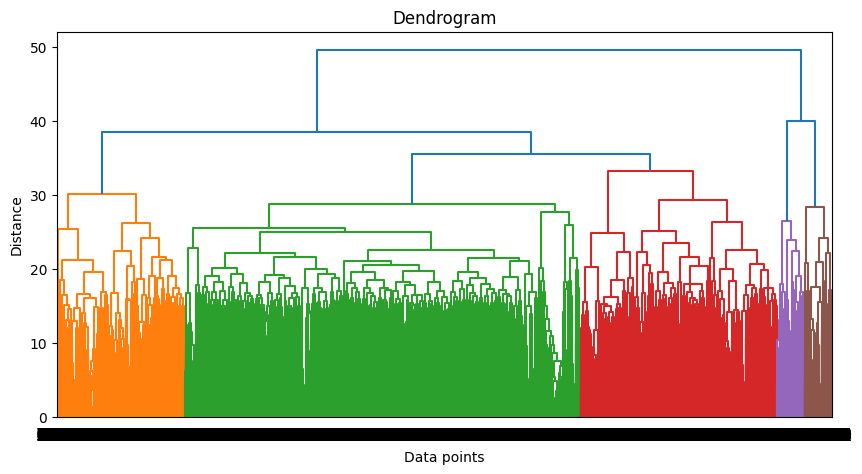

In [13]:
# Feature selection: runs in ~ 5min 
# Step 1: Identify feature clusters
# Create a dendrogram using hierarchical clustering
linkage = hierarchy.linkage(corr_matrix, method='complete')
plt.figure(figsize=(10, 5))
plt.title('Dendrogram')
plt.xlabel('Data points')
plt.ylabel('Distance')
hierarchy.dendrogram(
    linkage,
    leaf_rotation=0.,  # Rotate x-axis labels
    leaf_font_size=12.,  # Font size for x-axis labels
)
plt.show()

In [14]:
# Get clusters from the dendrogram
max_d = 15 # Maximum distance between clusters
clusters = hierarchy.fcluster(linkage, max_d, criterion='distance')

clusters

array([ 73, 213, 171, ..., 311, 213, 213], dtype=int32)

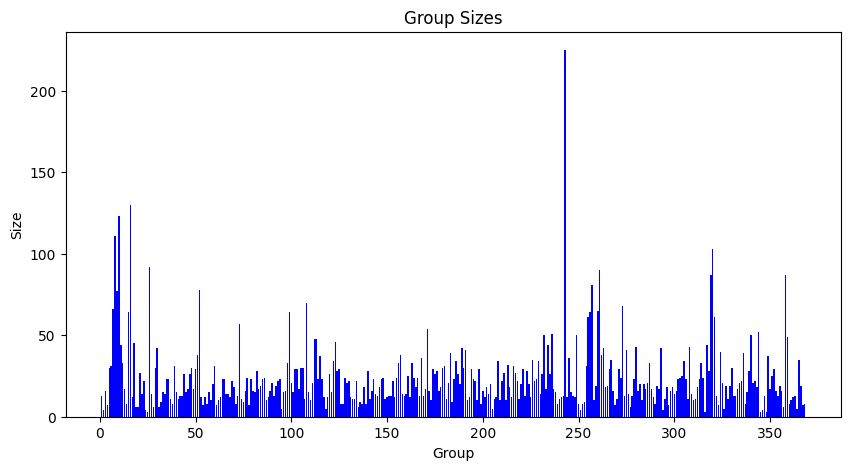

In [15]:
# Group columns by cluster
df = pd.DataFrame(corr_matrix)
df.columns = ['col_' + str(i) for i in range(df.shape[1])]
df['cluster'] = clusters
grouped = df.groupby('cluster')

# Get the size of each group
group_sizes = grouped.size()

# Plot the group sizes
plt.figure(figsize=(10,5))
plt.bar(x=group_sizes.index, height=group_sizes.values, color='blue')
plt.title('Group Sizes')
plt.xlabel('Group')
plt.ylabel('Size')
plt.show()

In [16]:
print(Y.shape)
print(X.shape)
print(len(clusters))

(104, 5)
(104, 8749)
8749


In [17]:
# Step 3: Calculate the correlation matrix between the columns of X and the columns of Y
corr_matrix = np.abs(np.corrcoef(X.T, Y.T)[:X.shape[1], X.shape[1]:])

# compute the row-wise averages of the matrix
avg_matrix = np.mean(corr_matrix, axis=1, keepdims=True)

# concatenate the average matrix with the group array
concat_matrix = np.concatenate([avg_matrix, clusters.reshape(len(clusters), 1)], axis=1)

# sort the concatenated matrix by group
sorted_matrix = concat_matrix[concat_matrix[:, -1].argsort()]

# find the maximum value in each group and its index
max_values = []
# iterate over the unique groups in the second column of the sorted matrix
for group in np.unique(sorted_matrix[:, 1]):
    # find the indices of rows that belong to the current group
    indices = np.where(sorted_matrix[:, 1] == group)[0]
    # get the maximum value in the first column for the current group
    max_value = np.max(sorted_matrix[indices, 0])
    # append the maximum value to the list
    max_values.append(max_value)
    
    
# find the indices of all the maximum values in the avg_matrix
max_indices = []
for max_value in max_values:
    indices = np.where(avg_matrix == max_value)[0]
    max_indices.extend(indices)

X_filtered = X.iloc[:, max_indices]
print(X_filtered.shape)



(104, 371)


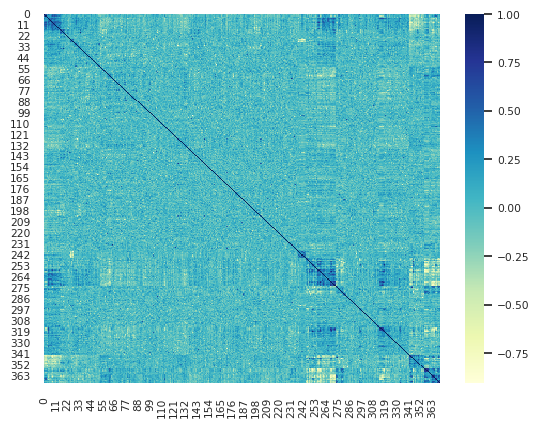

In [18]:
plot_correlation_matrix(X_filtered)

In [19]:
# # Feature selection
# # Step 1: Find index of feature columns with correlation greater than the threshold
# upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# threshold = 0.8
# to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

# # Step 2: Select one feature from each highly correlated pair
# chosen_features = []
# for col in to_drop:
#     correlated_cols = list(upper.index[upper[col] > threshold])
#     importance_scores = [Y[c].corr(X[col]) for c in correlated_cols]
#     best_idx = np.argmax(importance_scores)
#     chosen_features.append(correlated_cols[best_idx])

# # Step 3: Remove the remaining features
# X = X.drop(to_drop, axis=1)
# X = X[chosen_features]

In [20]:
# Ensemble feature selection (using voting) across multiple filter methods
# TODO: Maybe create seperate feature sets for each PERMA dimension seperatly?
def get_selected_features(Y, X_filtered, filter_methods):
    selected_features = []
    
    for i in range(Y.shape[1]):
        y_i = Y.iloc[:, i]
        selected_i = []
        
        for method_name, method in filter_methods.items():
            pipeline = Pipeline([(method_name, method), ('regressor', LinearRegression())])
            pipeline.fit(X_filtered, y_i)
            selected_i.append(pipeline.named_steps[method_name].get_support(indices=True))
        
        selected_i = np.concatenate(selected_i)
        selected_i = np.unique(selected_i)
        selected_features.append(selected_i)
        
    return np.concatenate(selected_features)

filter_methods = {
    'f_regression': SelectKBest(f_regression, k=1),
    'mutual_info_regression': SelectKBest(mutual_info_regression, k=1),
    'variance_threshold': VarianceThreshold(threshold=0.1),
}

all_selected_features = get_selected_features(Y, X_filtered, filter_methods)

print("Fused selected features:", all_selected_features)




Fused selected features: [159 228 233 259 261 329 108 159 181 233 259 329   7 159 233 259 329 342
  62  92 159 233 259 329  94 159 233 259 269 329]


In [ ]:
def get_selected_voting_features(Y, X_filtered, filter_methods, threshold: int =10):
    selected_features = []
    
    for i in range(Y.shape[1]):
        y_i = Y.iloc[:, i]
        selected_i = []
        
        for method_name, method in filter_methods.items():
            pipeline = Pipeline([(method_name, method), ('regressor', LinearRegression())])
            pipeline.fit(X_filtered, y_i)
            selected_i.append(pipeline.named_steps[method_name].get_support(indices=True))
        
        selected_i = np.concatenate(selected_i)
        selected_i = np.unique(selected_i)
        
        # Use ensemble feature selection using voting
        vote_counts = Counter(selected_i)
        voted_features = [k for k, v in vote_counts.items() if v > len(filter_methods) / 2]
        
        # Apply threshold on the number of returned features based on the counts of voted features
        if threshold > 0 and len(voted_features) > threshold:
            top_features = [feat for feat, count in vote_counts.most_common(threshold)]
        else:
            top_features = voted_features
        
        selected_features.append(top_features)
        
    return np.concatenate(selected_features)

filter_methods = {
    'f_regression': SelectKBest(f_regression, k=5),
    'mutual_info_regression': SelectKBest(mutual_info_regression, k=5),
    'variance_threshold': VarianceThreshold(threshold=0.1),
}

all_selected_ensemble_features = get_selected_voting_features(Y, X_filtered, filter_methods)

print("Fused selected features:", all_selected_ensemble_features)


In [21]:
len(set(all_selected_features))

14

['Sad__large_standard_deviation__r_0.2', 'Arousal__fft_coefficient__attr_"real"__coeff_31', 'Dominance__fft_coefficient__attr_"abs"__coeff_22', 'Happy__fft_coefficient__attr_"abs"__coeff_59', 'Brightness__large_standard_deviation__r_0.15000000000000002', 'Surprise__fft_coefficient__attr_"angle"__coeff_43', 'Surprise__fft_coefficient__attr_"angle"__coeff_92', 'Arousal__spkt_welch_density__coeff_2', 'Angry__fourier_entropy__bins_100', 'Neutral__lempel_ziv_complexity__bins_2', 'Neutral__fft_coefficient__attr_"real"__coeff_17', 'Arousal__fft_coefficient__attr_"angle"__coeff_46', 'Sad__fft_coefficient__attr_"imag"__coeff_84', 'Brightness__has_duplicate']


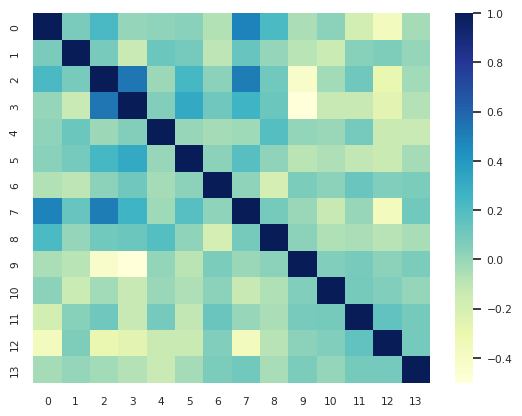

In [22]:
X_final = X_filtered.iloc[:, list(set(all_selected_features))]
plot_correlation_matrix(X_final)
column_names = X_final.columns.tolist()
print(column_names)

In [66]:
# Runs in ~5 min for n_fols=5
hyper_search = HyperparaSearch(models=MODELS, n_folds=5, n_jobs=-1)

results = hyper_search.run(X_final, Y, save=False)

Model: CatBoostRegressor
mean_squared_error: 0.807
mean_absolute_error: 0.713


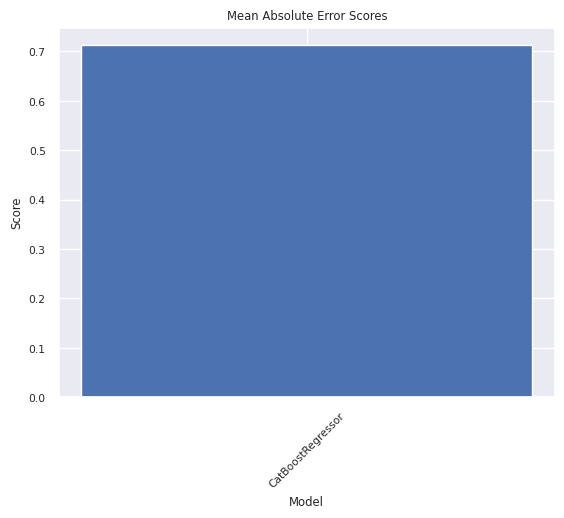

In [67]:
eval_metric = "mean_absolute_error"

# Plot the results
mae_scores = [
    rd["score"]
    for result_list in results
    for rd in result_list
    if rd["metric"] == eval_metric
]
model_names = [
    rd["name"]
    for result_list in results
    for rd in result_list
    if rd["metric"] == eval_metric
]
plt.bar(model_names, mae_scores)
plt.title("Mean Absolute Error Scores")
plt.xlabel("Model")
plt.ylabel("Score")
plt.xticks(rotation=45) 
plt.show()

In [68]:
# Print the model with the lowest score
best_model = min(
    [
        min(
            sublist,
            key=lambda x: x["score"]
            if x["metric"] == eval_metric
            else float("inf"),
        )
        for sublist in results
    ],
    key=lambda x: x["score"],
)
print(f"Best model: {best_model['name']}")
print(f"Best params: {best_model['params']}")
print(f"Best Score: {best_model['score']}")

Best model: CatBoostRegressor
Best params: {'estimator__depth': 3, 'estimator__iterations': 400, 'estimator__learning_rate': 0.01}
Best Score: 0.7126083071619734


In [ ]:
# Create a dictionary for each PERMA pillar
perma_dict = {
    "P": pd.DataFrame(),
    "E": pd.DataFrame(),
    "R": pd.DataFrame(),
    "M": pd.DataFrame(),
    "A": pd.DataFrame(),
}

filter_methods = {
    'f_regression': SelectKBest(f_regression, k=5),
    'mutual_info_regression': SelectKBest(mutual_info_regression, k=5),
    'variance_threshold': VarianceThreshold(threshold=0.1),
}


# Iterate over each PERMA dimension in Y
for i, perma_dim in enumerate(Y.columns):
    # Get the selected features for the current PERMA dimension
    selected_features = get_selected_voting_features(Y.iloc[:, i], X_filtered, filter_methods)
    # Save the selected features in the corresponding dictionary for the current PERMA pillar
    perma_dict[perma_dim] = selected_features

# Print the selected features for each PERMA dimension in each PERMA pillar
for pillar in perma_dict:
    print("Selected features for", pillar, "pillar:")
    for dim in perma_dict[pillar]:
        print(dim, ":", perma_dict[pillar][dim])
